In [2]:
import numpy as np, pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [3]:
# These are all of the files you are given
df_tr = pd.read_csv("train.csv")

In [4]:
df_tr

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."
...,...,...,...,...,...,...,...,...,...
1710665,1404171463620000698,C,NaN,NaN,20000698,1404171463,A,False,"[[-8.612469,41.14602],[-8.612487,41.145993],[-..."
1710666,1404171367620000670,C,NaN,NaN,20000670,1404171367,A,False,"[[-8.610138,41.140845],[-8.610174,41.140935],[..."
1710667,1388745716620000264,C,NaN,NaN,20000264,1388745716,A,False,[]
1710668,1404141826620000248,B,NaN,12.0,20000248,1404141826,A,False,"[[-8.630712,41.154885],[-8.63073,41.154813],[-..."


In [5]:
# Over every single 
def polyline_to_trip_duration(polyline):
  return max(polyline.count("[") - 2, 0) * 15

df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [6]:
from datetime import datetime
def parse_time(x):
  # We are using python's builtin datetime library
  # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

  # Each x is essentially a 1 row, 1 column pandas Series
  dt = datetime.fromtimestamp(x["TIMESTAMP"])
  return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [7]:
df_tr = df_tr[df_tr["MISSING_DATA"] == False] # clean out all missing data

In [8]:
# cab_data = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")
# cab_dict = {}
# for i in range(1, 64):
#     cab_dict[i] = (cab_data[cab_data["ID"] == i].values[0][2], cab_data[cab_data["ID"] == i].values[0][3])
# lat_mean = np.mean([cab_dict[i][0] for i in range(1, 64)])
# lat_std = np.std([cab_dict[i][0] for i in range(1, 64)])
# long_mean = np.mean([cab_dict[i][1] for i in range(1, 64)])
# long_std = np.std([cab_dict[i][1] for i in range(1, 64)])
# for i in range(1, 64):
#     old_lat = cab_dict[i][0]
#     old_long = cab_dict[i][1]
#     new_lat = (old_lat - lat_mean) / lat_std
#     new_long = (old_long - long_mean) / long_std
#     cab_dict[i] = (new_lat + 3, new_long + 3) # push up the z-normalized values so we can use 0 as a placeholder for "null"

In [9]:
# cab_data = pd.read_csv("metaData_taxistandsID_name_GPSlocation.csv")
# cab_dict = {}
# # for i in range(1, 64):
#     cab_dict[i] = (cab_data[cab_data["ID"] == i].values[0][2], cab_data[cab_data["ID"] == i].values[0][3])

In [10]:
# def get_lat_long(x):
#     i = x["ORIGIN_STAND"]
# #     if (i != i): return 0, 0 # placeholder for null values
#     i = int(i)
#     return cab_dict[i][0], cab_dict[i][1]

# df_tr[["LAT", "LONG"]] = df_tr[["ORIGIN_STAND"]].apply(get_lat_long, axis=1, result_type="expand")

In [ ]:
# print(len(df_tr))

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class TaxiDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_transform=None):
        self.dataframe = dataframe
        self.transform = None
        self.target_transform = None
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        entry = self.dataframe.iloc[idx]
        time = torch.tensor([entry["LEN"]]).to(torch.float32).to(device)
        if (entry["CALL_TYPE"] == "A"):
            call_type_onehot = [1, 0, 0]
        elif (entry["CALL_TYPE"] == "B"):
            call_type_onehot = [0, 1, 0]
        else: # call_type is C
            call_type_onehot = [0, 0, 1]
        if (entry["ORIGIN_STAND"] != entry["ORIGIN_STAND"]): # if ORIGIN_STAND is NaN
            # idea to do one-hot encoding comes from https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
            origin_stand = [0 for _ in range(63)]
        else:
            origin_stand = F.one_hot(torch.tensor(int(entry["ORIGIN_STAND"]) - 1), num_classes=63).tolist()
        feature_tuple = (*call_type_onehot, entry["HR"], *origin_stand)
        feature_tensor = torch.tensor(feature_tuple).to(torch.float32).to(device)
        return feature_tensor, time

In [39]:
len(df_tr)

1710660

In [13]:
# credit to https://stackoverflow.com/questions/54730276/how-to-randomly-split-a-dataframe-into-several-smaller-dataframes
shuffled = df_tr.sample(frac=1)
# result = np.array_split(shuffled, 100)
result = np.array_split(shuffled, 100)

In [14]:
train_df = pd.concat(result[:4])
# outlier_threshold = 3 # taking out anomalies has helped from my experience
# mean, std = train_df["LEN"].mean(), train_df["LEN"].std()
# train_df = train_df[train_df["LEN"] < mean + outlier_threshold * std]
test_df = result[-1]
train_set = TaxiDataset(train_df)
test_set = TaxiDataset(test_df)

In [39]:
train_df.to_csv("cropped_training_set.csv", index=None) # save these for later so we can make consistent comparisons
test_df.to_csv("cropped_test_set.csv", index=None)

In [46]:
train_df = pd.read_csv("cropped_training_set.csv")
test_df = pd.read_csv("cropped_test_set.csv")

In [47]:
from torch.utils.data import DataLoader

Features are going to be:
- call type - one hot encoded
- origin stand - one hot encoded
- length (in seconds)
- hour (of when the taxi travel time begun)

In [54]:
class Net(nn.Module): # CREDIT TO https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout for order
    def __init__(self, p):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(67, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, 128)
        self.layer4 = nn.Linear(128, 128)
        self.layer5 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(p=p)
        self.batchnorm1 = nn.BatchNorm1d(128)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(128)
        self.batchnorm4 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.batchnorm1(self.layer1(x)))
        x = self.relu(self.batchnorm2(self.dropout(self.layer2(x))))
        x = self.relu(self.batchnorm3(self.layer3(x)))
        x = self.relu(self.batchnorm4(self.dropout(self.layer4(x))))
        x = self.relu(self.layer5(x))
        return x

In [55]:
# code taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    model.eval()

def eval_train_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    train_loss = 0    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            train_loss += loss_fn(pred, y).item()
    train_loss /= num_batches
    train_loss

def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss
    
def std_loop(dataloader, model):
    results = []
    for (x, _) in dataloader:
        for singleton in model(x):
            results.append(singleton.item())
    return np.std(results)

In [64]:
def run_tests(batch_size=64, lr=1e-3, epochs=10, dropout=0.1):
    model = Net(dropout).to(device)
    # code adapted from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    exp_dict = {} # experiment results, as a dict
    exp_dict["epoch"] = []
    exp_dict["train_loss"] = []
    exp_dict["test_loss"] = []
    exp_dict["std"] = []

    for t in range(epochs):
        train_loop(train_loader, model, loss_fn, optimizer)
        exp_dict["epoch"].append(t + 1)
        exp_dict["train_loss"].append(eval_train_loop(train_loader, model, loss_fn))
        exp_dict["test_loss"].append(test_loop(test_loader, model, loss_fn))
        exp_dict["std"].append(std_loop(test_loader, model))
    
    return (model, pd.DataFrame(data=exp_dict))

In [136]:
(model, results_lr_1) = run_tests(lr=1e-3) # dropout is 0.1 by default

In [66]:
(model2, results_lr_2) = run_tests(lr=1e-4)

In [121]:
(model3, results_lr_3) = run_tests(lr=5e-4)

In [137]:
(model4, results_lr_4)= run_tests(lr=1.5e-3)

In [186]:
(model9, results_dropout_02) = run_tests(dropout=0.2, lr=5e-4)

In [187]:
(model10, results_dropout_03) = run_tests(dropout=0.3, lr=5e-4)

In [188]:
(model11, results_dropout_04) = run_tests(dropout=0.4, lr=5e-4)

In [189]:
(model12, results_dropout_05) = run_tests(dropout=0.5, lr=5e-4)

In [ ]:
(model13, results_dropout_02_lr_1) = run_tests(dropout=0.2)

In [203]:
(model14, results_dropout_03_lr_1) = run_tests(dropout=0.3)

In [204]:
(model15, results_dropout_04_lr_1) = run_tests(dropout=0.4)

In [205]:
(model16, results_dropout_05_lr_1) = run_tests(dropout=0.5)

In [220]:
(model17, results_dropout_0) = run_tests(dropout=0.0, lr=5e-4)

In [224]:
results_dropout_03["test_loss"]

0    833377.513701
1    619758.612931
2    498264.301656
3    460649.804862
4    451621.088532
5    448612.457993
6    451868.322732
7    451926.987786
8    448399.993179
9    448815.158291
Name: test_loss, dtype: float64

In [223]:
results_dropout_0["test_loss"]

0    832120.330224
1    602382.786031
2    471480.717497
3    447993.430066
4    442374.174411
5    444390.556582
6    445478.464713
7    441258.160069
8    441219.273671
9    441837.978720
Name: test_loss, dtype: float64

In [265]:
lr_results = pd.concat([results_lr_1["epoch"], results_lr_2["test_loss"], results_lr_3["test_loss"], results_lr_1["test_loss"], results_lr_4["test_loss"]], axis=1)

In [266]:
lr_results.columns = ["epoch", "1e-4 lr", "5e-4 lr", "1e-3 lr", "1.5e-3 lr"]

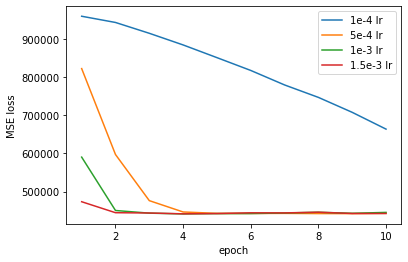

In [267]:
import matplotlib.pyplot as plt
ax = lr_results.set_index("epoch").plot()
ax.set_xlabel("epoch")
ax.set_ylabel("MSE loss")
plt.show()

In [84]:
def get_input_tensor(entry):
    if (entry["CALL_TYPE"] == "A"):
        call_type_onehot = [1, 0, 0]
    elif (entry["CALL_TYPE"] == "B"):
        call_type_onehot = [0, 1, 0]
    else: # call_type is C
        call_type_onehot = [0, 0, 1]
    if (entry["ORIGIN_STAND"] != entry["ORIGIN_STAND"]): # if ORIGIN_STAND is NaN
        # idea to do one-hot encoding comes from https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
        origin_stand = [0 for _ in range(63)]
    else:
        origin_stand = F.one_hot(torch.tensor(int(entry["ORIGIN_STAND"]) - 1), num_classes=63).tolist()
    feature_tuple = (*call_type_onehot, entry["HR"], *origin_stand)
    feature_tensor = torch.tensor(feature_tuple).to(torch.float32).to(device)
    return feature_tensor

I ran into a problem where the model would just output the exact same value every time. I combatted this by adding more layers + batch normalization + reduced learning rate + less epochs.

https://datascience.stackexchange.com/questions/58220/how-to-deal-with-a-constant-value-as-an-output-from-neural-network

https://stackoverflow.com/questions/4493554/neural-network-always-produces-same-similar-outputs-for-any-input

https://stackoverflow.com/questions/39217567/keras-neural-network-outputs-same-result-for-every-input

In [85]:
df_public_test = pd.read_csv("test_public.csv")
df_public_test[["YR", "MON", "DAY", "HR", "WK"]] = df_public_test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
pred_dict = {}
for row in df_public_test.iloc:
    pred_dict[row["TRIP_ID"]] = model(torch.unsqueeze(get_input_tensor(row), dim=0)).item()

In [70]:
def get_prediction(x):
    return pred_dict[x]

In [86]:
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")
df_sample["TRAVEL_TIME"] = df_sample["TRIP_ID"].apply(get_prediction)
df_sample.to_csv("my_pred.csv", index=None)

In [308]:
class LinReg(nn.Module):
    def __init__(self):
        super(LinReg, self).__init__()
        self.layer1 = nn.Linear(68, 1)
    
    def forward(self, x):
        x = self.layer1(x)
        return x

In [309]:
linreg_model = LinReg().to(device)

In [ ]:
# code taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
learning_rate = 0.001
batch_size = 64

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(linreg_model.parameters(), lr=learning_rate, weight_decay=0.99)
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, linreg_model, loss_fn, optimizer)
    test_loop(test_loader, linreg_model, loss_fn)
print("Done!")